# 11 - Modelling, hyperparameter tuning, and test data.

It's been a ride! Let's tune our model and check how it does on the testing data, comparing it to our dummy model.

In [11]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedGroupKFold

from imblearn.under_sampling import RandomUnderSampler

from imblearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, f1_score
from scipy.stats import randint

from sklearn.model_selection import RandomizedSearchCV

from warnings import simplefilter
simplefilter("ignore", category=UserWarning)

In [12]:
train = pd.read_csv('encoded_train.csv')
test = pd.read_csv('encoded_test.csv')

groups = train['accident_index'].copy().tolist()

y_train = train['casualty_severity']
X_train = train.drop(['casualty_severity', 'accident_index'], axis=1)

y_test = test['casualty_severity']
X_test = test.drop(['casualty_severity', 'accident_index'], axis=1)

In [13]:
X_test.head()

,number_of_vehicles,number_of_casualties,first_road_class,road_type,speed_limit,junction_detail,second_road_class,pedestrian_crossing_physical_facilities,light_conditions,urban_or_rural_area,trunk_road_flag,sex_of_casualty,age_band_of_casualty,casualty_type,high_winds,pedestrian_in_carriageway,rushhour,nighttime,weekend
0,0.252679,0.304636,0.275732,0.3081,0.294521,0.300993,0.300993,0.28465,0.262131,0,0,0,0.234136,0.307692,0,0,0,0,1
1,0.398473,0.304636,0.311237,0.3081,0.294521,0.299270,0.204082,0.28465,0.262131,0,0,1,0.319876,0.388626,0,1,0,0,0
2,0.252679,0.304636,0.311237,0.3081,0.288991,0.299270,0.301141,0.28465,0.347889,0,0,0,0.243243,0.221841,0,0,0,1,1
3,0.398473,0.304636,0.311237,0.3081,0.294521,0.305466,0.301141,0.28465,0.320346,0,0,0,0.247261,0.388626,0,1,0,1,0
4,0.252679,0.304636,0.311237,0.3081,0.294521,0.299270,0.301141,0.28465,0.262131,0,0,1,0.243243,0.221841,0,0,1,0,0


In [17]:
pipeline = make_pipeline(RandomUnderSampler(random_state=42),
                         RandomForestClassifier())

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True)
mean_score = cross_val_score(pipeline, X_train, y_train, scoring='f1', cv=sgkf, groups=groups).mean()
print("The mean F1 score for 5-fold stratified cross-validation on our randomly oversampled dataset is {:.2f}".format(mean_score))


The mean F1 score for 5-fold stratified cross-validation on our randomly oversampled dataset is 0.44


In [18]:
# Evaluate the tuned pipeline on the test set
clf = pipeline.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Classification Report for the Tuned Model:")
print(classification_report(y_test, y_pred))

# Test accuracy
accuracy = f1_score(y_test, y_pred)
print(f"Test F1 before Hyperparameter Tuning: {accuracy:.4f}")

Classification Report for the Tuned Model:
              precision    recall  f1-score   support

           0       0.81      0.51      0.63      2004
           1       0.37      0.70      0.48       810

    accuracy                           0.57      2814
   macro avg       0.59      0.61      0.55      2814
weighted avg       0.68      0.57      0.59      2814

Test F1 before Hyperparameter Tuning: 0.4824


Okay, let's try and boost that number a little bit.


In [19]:
param_space= {
    'randomforestclassifier__n_estimators': randint(50, 500),  # Number of trees in the forest
    'randomforestclassifier__max_depth': [None] + list(range(5, 31, 1)),  # Depth of the trees
    'randomforestclassifier__min_samples_split': randint(2, 20),  # Minimum samples required to split
    'randomforestclassifier__min_samples_leaf': randint(1, 10),  # Minimum samples required per leaf
    'randomforestclassifier__max_features': ['sqrt', 'log2', None]  # Number of features to consider for the best split
}

In [21]:
random_search = RandomizedSearchCV(pipeline, param_distributions=param_space, n_iter=100, scoring='f1', n_jobs=-1, cv=sgkf, verbose=2, random_state=42)
random_search.fit(X_train, y_train, groups=groups)



Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedGroupKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('randomundersampler',
                                              RandomUnderSampler(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': [None,
                                                                              5,
                                                                              6,
                                                                              7,
                                                                              8,
                                                                              9,
                                                                              10,
                                                                              11,
                                                                              12,
                                                                              13,
                                                                              14,
                                                                              15,
                                                                              16,
                                                                              17,
                                                                              18,
                                                                              19,
                                                                              2...
                                        'randomforestclassifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000204B56116A0>,
                                        'randomforestclassifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000204B56118B0>,
                                        'randomforestclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000204B555A090>},
                   random_state=42, scoring='f1', verbose=2)

In [22]:
print(f"Best Parameters: {random_search.best_params_}")

print("Best CV F1 score on Training Data: {:.3f}".format(random_search.best_score_))

best_pipeline = random_search.best_estimator_

Best Parameters: {'randomforestclassifier__max_depth': 12, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 8, 'randomforestclassifier__min_samples_split': 18, 'randomforestclassifier__n_estimators': 351}
Best CV F1 score on Training Data: 0.491


Okay, hyperparameter tuning has given an extra 1% absolute increase in cross-validated F1 score on our training data. 

I think it's finally time to see what happens when we predict on the testing data.

In [23]:
# Evaluate the tuned pipeline on the test set
y_pred = best_pipeline.predict(X_test)

print("Classification Report for the Tuned Model:")
print(classification_report(y_test, y_pred))

# Test accuracy
accuracy = f1_score(y_test, y_pred)
print(f"Test F1 after Hyperparameter Tuning: {accuracy:.4f}")

Classification Report for the Tuned Model:
              precision    recall  f1-score   support

           0       0.84      0.47      0.60      2004
           1       0.37      0.77      0.50       810

    accuracy                           0.56      2814
   macro avg       0.60      0.62      0.55      2814
weighted avg       0.70      0.56      0.57      2814

Test F1 after Hyperparameter Tuning: 0.5020


___

# Our results:

Okay, we've got a 0.43 F1 score on our testing data set. This isn't great, but our dummy classifier was around 0.28. This means our feature engineering and selection has lead to a 54% increase in our scoring metric.


Once last thing that I'd like to do: our model has set a default threshold of 0.5 to determine the classification of the predictions. Is this optimal for our case? 

Precision is important as we want to be confident about our severe collisions predictions. If we have limited resources for intervention, we don't want to expend them when we arnen't confident.

Recall is important as we want to identify as many severe collisions as possible, even at the cost of some false positives.

F1 score has been used to balance these two things, however, we could consider recall to be the most important metric in this case. 

Let's see if we can adjust our threshold to boost the recall.

___

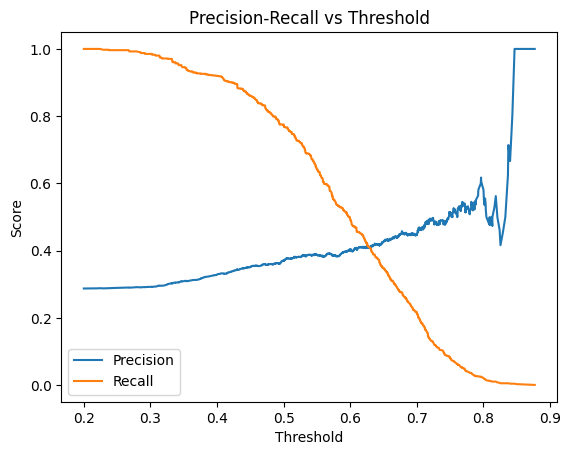

In [25]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


y_proba = best_pipeline.predict_proba(X_test)[:, 1]


# Compute precision-recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Plot Precision-Recall Curve
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall vs Threshold")
plt.show()

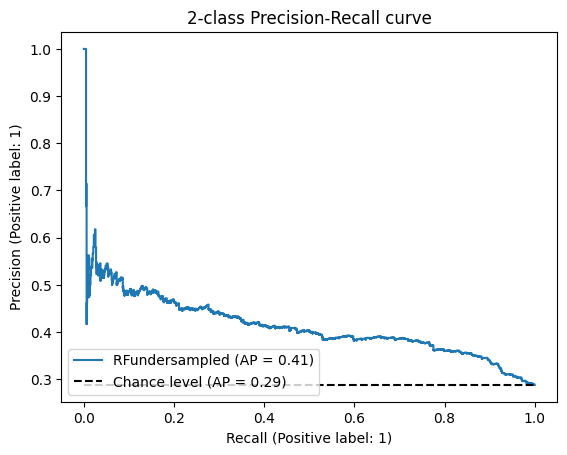

In [29]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    best_pipeline, X_test, y_test, name="RFundersampled", plot_chance_level=True)
_ = display.ax_.set_title("2-class Precision-Recall curve")

## Let's use SHAP to interpret our model.

In [143]:
best_pipeline.named_steps['randomforestclassifier'].feature_importances_.shape

(19,)

---
# Let's reduce the number of features

In [32]:
importances = best_pipeline.named_steps['randomforestclassifier'].feature_importances_
feature_names = X_train.columns


# Create a DataFrame for easy visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances with their names
print(feature_importance_df)

                                    Feature  Importance
13                            casualty_type    0.209499
12                     age_band_of_casualty    0.121991
0                        number_of_vehicles    0.104942
11                          sex_of_casualty    0.070602
4                               speed_limit    0.068729
5                           junction_detail    0.058422
2                          first_road_class    0.050137
1                      number_of_casualties    0.043913
6                         second_road_class    0.042741
3                                 road_type    0.037923
8                          light_conditions    0.034386
17                                nighttime    0.029354
9                       urban_or_rural_area    0.025199
16                                 rushhour    0.024830
7   pedestrian_crossing_physical_facilities    0.023925
18                                  weekend    0.023818
15                pedestrian_in_carriageway    0

In [37]:
f1_list = []

for n in range(1, X_train.shape[1]):
  top_n_feats = list(feature_importance_df.Feature[:n])
  print(top_n_feats,'\n')
  X_train_reduced = X_train[top_n_feats]
  X_test_reduced = X_test[top_n_feats]
  clf = pipeline.fit(X_train_reduced, y_train)
  y_pred = clf.predict(X_test_reduced)
  # Test accuracy
  f1 = f1_score(y_test, y_pred)
  f1_list.append(f1)


  

['casualty_type'] 

['casualty_type', 'age_band_of_casualty'] 

['casualty_type', 'age_band_of_casualty', 'number_of_vehicles'] 

['casualty_type', 'age_band_of_casualty', 'number_of_vehicles', 'sex_of_casualty'] 

['casualty_type', 'age_band_of_casualty', 'number_of_vehicles', 'sex_of_casualty', 'speed_limit'] 

['casualty_type', 'age_band_of_casualty', 'number_of_vehicles', 'sex_of_casualty', 'speed_limit', 'junction_detail'] 

['casualty_type', 'age_band_of_casualty', 'number_of_vehicles', 'sex_of_casualty', 'speed_limit', 'junction_detail', 'first_road_class'] 

['casualty_type', 'age_band_of_casualty', 'number_of_vehicles', 'sex_of_casualty', 'speed_limit', 'junction_detail', 'first_road_class', 'number_of_casualties'] 

['casualty_type', 'age_band_of_casualty', 'number_of_vehicles', 'sex_of_casualty', 'speed_limit', 'junction_detail', 'first_road_class', 'number_of_casualties', 'second_road_class'] 

['casualty_type', 'age_band_of_casualty', 'number_of_vehicles', 'sex_of_casualty

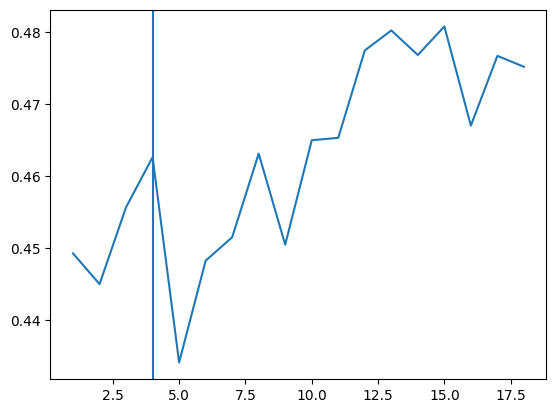

In [38]:
n = np.arange(1, X_train.shape[1])
plt.plot(n, f1_list)
plt.axvline(4)